# Docking Pose Confidence GNN with Global Context
*By: Oliver Cheng*

In order to improve on the confidence model that came with DiffDock, I added to the original DiffDock Confidence model (Cusco et al 2022) by including a global context which allows different parts of the graph that would normally not be connected with each other to communicate via the GNN convolutional layers. The presentation will contain the exact parts of the code I modified. The `README.md` at will help set-up the environment. The contents of this notebook are as follows

1. Using ESM2 in order to make embeddings for our protein files.
2. Training our confidence model.
3. Constructing a test dataset `MiniInferenceDataset` that we can use the model on.
4. Performing inference on our confidence model and analyzing.

Many parts of the structure of this model are identical to that of DiffDock's model, hence one can skip ahead if familiar with DiffDock. With a goal of computing the confidence/ranking of poses that are output from the DiffDock diffusion model, the ligand and protein are represented as a graph. For our purposes, this is a three-way heterogenous graph (`torch_geometric.data.HeteroData()`). We first independently construct graphs for the ligand, protein, and a global context. For the ligand and protein, each atom is a node and edges represent bonds. Features of the node include chirality, atom type, etc. and features of the edge are primarily bond type and rotational/torsional angles. Note that our featurization enables SE(3) invariance, as rotating the entire ligand or protein will not change any of these values. The global context consists of a single node. 

There are also edges that cross between the different heterogenous graphs, in particular both between the protein and ligand and the ligand and global context. Between the protein and ligand, existence of an edge and its attributes are defined by the distance between the corresponding atoms. All cross edges are SO(3) equivariant, implemented using the `e3nn` package. 

We used 2 convolutional layers to message pass between the nodes of the graph. This meant that any specific ligand node or edge had messages passed from every other node and edge. What this. Theoretically, this allows the ligand representations to take in information about parts of the molecule that are far away. For example, if one sidechain is particularly strained, ordinarily it would take many convolutional layers for a sidechain on the other end of the molecule to have information regarding this strain, but with the global context, this can be done quickly. 

In order to perform a confidence prediction, all ligand data is pooled and an 2-layer MLP is trained to take this embedding and output a prediction on how close the docked pose is to the true crystal pose. The model is trained on loss generated by the RMSD between the two poses. 

## Imports

In [1]:
import os
import yaml
import tqdm
import sys
sys.path.append("DiffDock/esm")

#with open("environment.yml") as file_handle:
#    environment_data = yaml.safe_load(file_handle)

#for dependency in environment_data["dependencies"]:
#    if isinstance(dependency, dict):
#      for lib in dependency['pip']:
#        os.system(f"pip install {lib}")

%env HOME=esm/model_weights

from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


import torch


import yaml
from argparse import Namespace
%cd DiffDock
from utils.diffusion_utils import t_to_sigma as t_to_sigma_compl
from utils.diffusion_utils import set_time
from utils.utils import get_model
from datasets.process_mols import parse_pdb_from_path, generate_conformer, read_molecule, get_lig_graph_with_matching, \
    extract_receptor_structure, get_rec_graph
from utils.inference_utils import get_sequences_from_pdbfile, compute_ESM_embeddings

%cd ..

from functools import partial
import os

import torch
from Bio.PDB import PDBParser
import esm
from esm import FastaBatchedDataset, pretrained
from rdkit import Chem
from rdkit.Chem import AddHs, MolFromSmiles, AllChem
from torch_geometric.data import Dataset, HeteroData

import pandas as pd
import numpy as np
import re

from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

env: HOME=esm/model_weights
/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/DiffDock


/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_sparse/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <A8501120-D534-32DE-962D-8D8010EAB01F> /Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_sparse/_version_cpu.so
  Expected in:     <AA553829-6BF2-3EE3-BC86-9CC58C36445E> /Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


/Users/seesea/Documents/Coding-Projects/vant-ai-oliver


## Data Parsing
Note that DiffDock cleans our data quite well, so all that is needed is to adjust our splits for training.

In [52]:
import os


data_path = "[INSERT_DATA_PATH_HERE]"

train = 400 # This is the computational limit of my cpu
val = 500
test = 600

count = 0
with open("DiffDock/data/splits/timesplit_no_lig_overlap_train", "w") as f:
  for name in os.listdir(data_path):
    f.write(f"{name}\n")
    count +=1
    if count > train:
      break

with open("DiffDock/data/splits/timesplit_no_lig_overlap_val", "w") as f:
  for vi, name in enumerate(os.listdir(data_path)):
    if vi <= train:
      continue
    f.write(f"{name}\n")
    count +=1

    if count > val:
      break

with open("DiffDock/data/splits/timesplit_test", "w") as f:
  for ti, name in enumerate(os.listdir(data_path)):
    if ti <= val:
      continue
    f.write(f"{name}\n")
    count +=1
    if count > test:
      break

We call DiffDock's file parsing functions to embed the protein data correctly. All embeddings are cached into the working directory.

In [3]:
%cd DiffDock
!python datasets/pdbbind_lm_embedding_preparation.py --data_dir [INSERT_DATA_DIR_HERE]

/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/DiffDock
  1%|▎                                          | 5/731 [00:00<00:30, 23.52it/s]encountered unknown AA:  KCX  in the complex  4mfe . Replacing it with a dash - .
encountered unknown AA:  KCX  in the complex  4mfe . Replacing it with a dash - .
encountered unknown AA:  KCX  in the complex  4mfe . Replacing it with a dash - .
encountered unknown AA:  KCX  in the complex  4mfe . Replacing it with a dash - .
  1%|▌                                         | 10/731 [00:00<00:57, 12.59it/s]encountered unknown AA:  LLP  in the complex  2qn3 . Replacing it with a dash - .
encountered unknown AA:  LLP  in the complex  2qn3 . Replacing it with a dash - .
  7%|██▉                                       | 51/731 [00:03<00:45, 14.82it/s]encountered unknown AA:  TPO  in the complex  5uir . Replacing it with a dash - .
encountered unknown AA:  SEP  in the complex  5uir . Replacing it with a dash - .
 25%|██████████                         

In [4]:
%env HOME=esm/model_weights
%env PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
!python esm/scripts/extract.py esm2_t33_650M_UR50D data/pdbbind_sequences.fasta data/embeddings_output --repr_layers 33 --include per_tok --truncation_seq_length 4096
!python datasets/esm_embeddings_to_pt.py

env: HOME=esm/model_weights
env: PYTHONPATH=$PYTHONPATH:/content/DiffDock/esm
Read data/pdbbind_sequences.fasta with 1381 sequences
Processing 1 of 98 batches (57 sequences)
Processing 2 of 98 batches (40 sequences)
Processing 3 of 98 batches (38 sequences)
Processing 4 of 98 batches (35 sequences)
Processing 5 of 98 batches (32 sequences)
Processing 6 of 98 batches (29 sequences)
Processing 7 of 98 batches (28 sequences)
Processing 8 of 98 batches (27 sequences)
Processing 9 of 98 batches (27 sequences)
Processing 10 of 98 batches (26 sequences)
Processing 11 of 98 batches (25 sequences)
Processing 12 of 98 batches (25 sequences)
Processing 13 of 98 batches (24 sequences)
Processing 14 of 98 batches (23 sequences)
Processing 15 of 98 batches (22 sequences)
Processing 16 of 98 batches (22 sequences)
Processing 17 of 98 batches (21 sequences)
Processing 18 of 98 batches (20 sequences)
Processing 19 of 98 batches (20 sequences)
Processing 20 of 98 batches (19 sequences)
Processing 21 of 

## Training
All model architecture and training modifications were made inside the forked DiffDock repository. See https://github.com/RubberNoodles/vant-ai-oliver for details. In particular, see `DiffDock/models/score_model.py` between https://github.com/gcorso/DiffDock and my code with the global context added. In the commentary section, I will discuss the limitations to my code. Unfortunately due to some network issues I had to reset the git repo (accidentally made an early commit with 100+ models that was too large to be pushed).

Note: if you find you are having errors, try deleting the cache. Also, hyperparameter tuning was omitted for time purposes--it is fairly standard to use GridSearch or probabilistic methods to optimize the hyperparameters (depending on computational resources).

In [54]:
%cd DiffDock

/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/DiffDock


In [55]:
!python -m train --run_name small_score_model --data_dir [INSERT_DATA_DIR_HERE] --no_batch_norm --test_sigma_intervals --esm_embeddings_path data/esm2_3billion_embeddings.pt --log_dir workdir --lr 1e-3 --tr_sigma_min 0.1 --tr_sigma_max 34 --rot_sigma_min 0.03 --rot_sigma_max 1.55 --batch_size 8 --ns 12 --nv 6 --num_conv_layers 2 --dynamic_max_cross --scheduler plateau --scale_by_sigma --dropout 0.1 --remove_hs --c_alpha_max_neighbors 10 --receptor_radius 5 --num_dataloader_workers 1 --cudnn_benchmark --val_inference_freq 5 --num_inference_complexes 10 --use_ema --scheduler_patience 30 --n_epochs 2


python(93333) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_sparse/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <A8501120-D534-32DE-962D-8D8010EAB01F> /Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_sparse/_version_cpu.so
  Expected in:     <AA553829-6BF2-3EE3-BC86-9CC58C36445E> /Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing complexes from [data/splits/timesplit_no_lig_overlap_train] and saving it to [data/cache_torsion/limit0_INDEXtimesplit_no_lig_overlap_train_maxLigSizeNone_H0_recRad5.0_re

In [56]:
!python -m confidence.confidence_train --original_model_dir workdir/small_score_model --data_dir [INSERT_DATA_DIR_HERE] --run_name confidence_model --inference_steps 20 --samples_per_complex 7 --batch_size 16 --n_epochs 10 --lr 3e-4 --scheduler_patience 50 --ns 24 --nv 6 --num_conv_layers 2 --dynamic_max_cross --scale_by_sigma --dropout 0.1 --all_atoms --remove_hs --c_alpha_max_neighbors 12 --receptor_radius 5 --esm_embeddings_path data/esm2_3billion_embeddings.pt --main_metric confidence_loss --main_metric_goal min --best_model_save_frequency 5 --rmsd_classification_cutoff 2 --cache_creation_id 2 --cache_ids_to_combine 1

python(93972) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_sparse/_version_cpu.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <A8501120-D534-32DE-962D-8D8010EAB01F> /Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch_sparse/_version_cpu.so
  Expected in:     <AA553829-6BF2-3EE3-BC86-9CC58C36445E> /Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-le

Note that the model is currently not taking in extra data, but rather computing new features directly from the input data. Hence our final model signature is the same as that of DiffDock's.

In [57]:
confidence_model_dir = "workdir/confidence_model" # trained model.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if confidence_model_dir is not None:
    with open(f'{confidence_model_dir}/model_parameters.yml') as f:
        confidence_args = Namespace(**yaml.full_load(f))

t_to_sigma = partial(t_to_sigma_compl, args=confidence_args)
confidence_model = get_model(confidence_args, device, t_to_sigma=t_to_sigma, no_parallel=True, confidence_mode=True)
confidence_model

/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/seesea/Documents/Coding-Projects/vant-ai-oliver/env/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in th

TensorProductScoreModel(
  (lig_node_embedding): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 24)
      (1): Embedding(4, 24)
      (2-3): 2 x Embedding(12, 24)
      (4): Embedding(8, 24)
      (5): Embedding(10, 24)
      (6-7): 2 x Embedding(6, 24)
      (8): Embedding(2, 24)
      (9): Embedding(8, 24)
      (10-15): 6 x Embedding(2, 24)
    )
    (linear): Linear(in_features=32, out_features=24, bias=True)
  )
  (lig_edge_embedding): Sequential(
    (0): Linear(in_features=68, out_features=24, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=24, out_features=24, bias=True)
  )
  (rec_node_embedding): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(38, 24)
    )
    (linear): Linear(in_features=32, out_features=24, bias=True)
    (lm_embedding_layer): Linear(in_features=1304, out_features=24, bias=True)
  )
  (rec_edge_embedding): Sequential(
    (0): Linear(in_features=64, out_fe

## Inference and Analysis
With the model trained and loaded as `confidence_model`, we can begin performing inference on the provided dataset by Vant. The rankings we output will coincide with the confidences that our output achieves. The following code block contains a `torch_geometric.data.Dataset` class that we will load into memory. This is based on `InferenceDataset` in `utils/inference_utils.py` in the DiffDock repository and simply constructs our graph in a way our confidence model can perform inference on. 

In addition, I add a few helper functions in order to compute crucial values that we will analyze after inference.

In [58]:
class MiniInferenceDataset(Dataset):
    def __init__(self, data, complex_names, protein_files, ligand_dirs, ligand_files, lm_embeddings, onfidence_args,):
        super(MiniInferenceDataset, self).__init__()
        self.complex_names = data[complex_names]
        self.protein_files = data[protein_files]
        self.lm_embeddings = data[lm_embeddings]
        self.ligand_dirs = data[ligand_dirs]
        self.ligand_files = ligand_files
        self.confidence_args = confidence_args
        self.data=data
        
    def len(self):
        
        return self.data.num_poses.sum()

    def get(self, index):
        """Output graph to input into the model for ligand corresponding to `ligand_files[index]`"""
        mask = (self.data['start_ind'] <= index) & (self.data['end_ind'] >= index)
        result_df = self.data[mask]
        idx = result_df.index[0]
        
        name, protein_file, ligand_dir, lm_embedding = \
            self.complex_names[idx], self.protein_files[idx], self.ligand_dirs[idx], self.lm_embeddings[idx]

        lig_path = os.path.join(ligand_dir, self.ligand_files[index])
        # build the pytorch geometric heterogeneous graph
        #print(name, protein_file, ligand_description, lm_embedding)
        complex_graph = HeteroData()
        complex_graph['name'] = [name, self.ligand_files[index]]
        complex_graph['index'] = index
        complex_graph['dir'] = ligand_dir
        
        # parse the ligand, either from file or smile
        try:
            mol = MolFromSmiles(lig_path)  # check if it is a smiles or a path
        
            if mol is not None:
                mol = AddHs(mol)
                generate_conformer(mol)
            else:
                mol = read_molecule(lig_path, remove_hs=False, sanitize=True)
                if mol is None:
                    raise Exception('RDKit could not read the molecule ', lig_path)
                mol.RemoveAllConformers()
                mol = AddHs(mol)
                generate_conformer(mol)
        except Exception as e:
            print('Failed to read molecule ', lig_path, ' We are skipping it. The reason is the exception: ', e)
            complex_graph['success'] = False
            
        
        try:
            # parse the receptor from the pdb file
            rec_model = parse_pdb_from_path(protein_file)
            get_lig_graph_with_matching(mol, complex_graph, popsize=None, maxiter=None, matching=False, keep_original=False,
                                        num_conformers=1, remove_hs=False)
            rec, rec_coords, c_alpha_coords, n_coords, c_coords, embeddings = extract_receptor_structure(rec_model, mol, lm_embedding_chains=lm_embedding)
            if embeddings is not None and len(c_alpha_coords) != len(embeddings):
                print(f'LM embeddings for complex {name} did not have the right length for the protein. Skipping {name}.')
                complex_graph['success'] = False
                
            
            get_rec_graph(rec, rec_coords, c_alpha_coords, n_coords, c_coords, complex_graph, rec_radius=5, all_atoms = confidence_args.all_atoms, lm_embeddings=embeddings)
        except Exception as e:
            print(f'Skipping {name} because of the error:')
            print(e)
            complex_graph['success'] = False
            return complex_graph
            
        protein_center = torch.mean(complex_graph['receptor'].pos, dim=0, keepdim=True)
        complex_graph['receptor'].pos -= protein_center
        
        if self.confidence_args.all_atoms:
            complex_graph['atom'].pos -= protein_center
        
        ligand_center = torch.mean(complex_graph['ligand'].pos, dim=0, keepdim=True)
        complex_graph['ligand'].pos -= ligand_center
        
        complex_graph.original_center = protein_center
        complex_graph.mol = mol
        complex_graph['success'] = True
        
        complex_graph.complex_t = {'tr': 0 * torch.ones(1), 'rot': 0 * torch.ones(1), 'tor': 0 * torch.ones(1)} # noise for diffusion model
        set_time(complex_graph, 0, 0, 0, 1, self.confidence_args.all_atoms, device)
        return complex_graph

def k_rmsd(P, Q):
    # Center the two sets of coordinates
    P -= np.mean(P, axis=0)
    Q -= np.mean(Q, axis=0)
    C = np.dot(np.transpose(P), Q)
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W))<0.0
    if d:
       S[-1] = -S[-1]
       V[:,-1] = -V[:,-1]
    U = np.dot(V, W)
    P_rot = np.dot(P, U)
    return np.sqrt(np.mean(np.square(P_rot - Q)))

def sym_rmsd(coords1, coords2):
    # Calculate the RMSD for both orderings and return the symmetric RMSD
    rmsd1 = k_rmsd(coords1, coords2)
    rmsd2 = k_rmsd(coords2, coords1)
    return min(rmsd1, rmsd2)

def rmsd(coords1, coords2):
    return np.sqrt(np.mean(np.square(coords1-coords2)))
    
def calc_energy(mol):
    AllChem.AssignStereochemistry(mol)
    properties = Chem.rdForceFieldHelpers.MMFFGetMoleculeProperties(mol)
    ff = Chem.rdForceFieldHelpers.MMFFGetMoleculeForceField(mol, properties)
    E = ff.CalcEnergy()
    return E

def get_mol_pos(mol):
    """Get the positions from an rdkit molecule. Expects 3d positions to already be encoded in file."""
    mol = Chem.RemoveHs(mol)
    if mol.GetNumConformers() == 0:
        return None, True
    true_conf = mol.GetConformer()
    true_pos = true_conf.GetPositions()
    return true_pos, False


def get_lig_pose_dir(name):
    path = os.path.join(dir, name, "poses")
    return path if os.path.isdir(path) else pd.NA



In [59]:
# Go to root directory
%cd ..

/Users/seesea/Documents/Coding-Projects/vant-ai-oliver


We load all of our data given from Vant into memory. We also run our esm model on the protein files in order to obtain esm embeddings.

In [76]:
dir = "[INSERT_DATA_DIR_HERE]"
data_df = pd.read_csv("[INSERT SPLITS HERE]")
data_df = data_df.rename(columns = {'id': 'complex_name'})
test_names = [name[0] for name in pd.read_csv("DiffDock/data/splits/timesplit_test").values.tolist()]
data_df = data_df[data_df.complex_name.isin(test_names)] # Only consider test data
print(data_df.head())

data_df['protein_files'] = data_df['complex_name'].apply(lambda name: os.path.join(dir, name, f"{name}_protein_processed.pdb"))
data_df['true_ligand'] = data_df['complex_name'].apply(lambda name: os.path.join(dir, name, f"{name}_ligand.sdf"))
data_df['low_strain_ligand']  = data_df['complex_name'].apply(lambda name: os.path.join(dir, name, f"{name}_ligand_low_strain_energy_conformer.sdf"))
data_df['ligand_dirs'] = data_df['complex_name'].apply(get_lig_pose_dir)
data_df = data_df.dropna()
data_df['num_poses'] = data_df['ligand_dirs'].apply(lambda path: len(os.listdir(path))-1)
data_df['start_ind'] = data_df['num_poses'].cumsum(axis = 0) - data_df['num_poses'].iloc[0]
data_df['end_ind'] = data_df['num_poses'].cumsum(axis = 0) - 1

ligand_descriptors = []
for i, pose_dir in enumerate(data_df['ligand_dirs']):
    lig_pose_files = os.listdir(pose_dir)
    
    #pattern = re.compile(r'*confidence*')  # regex for confidence*num* in filename
    only_confidence_poses = list(filter(lambda x: "confidence" in x, lig_pose_files))
    ligand_descriptors += only_confidence_poses
    
    assert data_df['num_poses'].iloc[i] == len(only_confidence_poses), pose_dir

   uniprot complex_name                                             smiles  \
7   O38732         3dcr  CCCC[C@H](CC(O)(O)[C@H](CCCC)NC(=O)[C@@H](NC(=...   
12  P0A434         1qw7                          CCOP(=O)(Cc1ccc(C)cc1)OCC   
23  A5K4U6         5hn8             CCCCCCCCOc1cc(O)cc(CSc2ccccc2C(=O)O)c1   
25  B0R5M0         2vx9  Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)...   
29  Q9BUZ4         5yc1  CC(C)C[C@H](NC(=O)[C@@H]([NH3+])CCCNC(=N)N)C(=...   

                       inchikey  pChembl  
7   GHZIZWOGRIROFP-WZGNFWQUSA-O     8.20  
12  QKGBKPZAXXBLJE-UHFFFAOYSA-N     3.60  
23  VWFBKLSSSBBNHA-UHFFFAOYSA-M     4.01  
25  AUNGANRZJHBGPY-SCRDCRAPSA-N     7.44  
29  BVVWBMWBBCDESV-VMXHOPILSA-Q     4.34  


In [77]:
import copy
import os
import warnings

import numpy as np
import scipy.spatial as spa
from Bio.PDB import PDBParser
from Bio.PDB.PDBExceptions import PDBConstructionWarning
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Geometry import Point3D
from scipy import spatial
from scipy.special import softmax



biopython_parser = PDBParser()
periodic_table = GetPeriodicTable()
allowable_features = {
    'possible_atomic_num_list': list(range(1, 119)) + ['misc'],
    'possible_chirality_list': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER'
    ],
    'possible_degree_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'possible_numring_list': [0, 1, 2, 3, 4, 5, 6, 'misc'],
    'possible_implicit_valence_list': [0, 1, 2, 3, 4, 5, 6, 'misc'],
    'possible_formal_charge_list': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'possible_numH_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 'misc'],
    'possible_number_radical_e_list': [0, 1, 2, 3, 4, 'misc'],
    'possible_hybridization_list': [
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'
    ],
    'possible_is_aromatic_list': [False, True],
    'possible_is_in_ring3_list': [False, True],
    'possible_is_in_ring4_list': [False, True],
    'possible_is_in_ring5_list': [False, True],
    'possible_is_in_ring6_list': [False, True],
    'possible_is_in_ring7_list': [False, True],
    'possible_is_in_ring8_list': [False, True],
    'possible_amino_acids': ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET',
                             'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'HIP', 'HIE', 'TPO', 'HID', 'LEV', 'MEU',
                             'PTR', 'GLV', 'CYT', 'SEP', 'HIZ', 'CYM', 'GLM', 'ASQ', 'TYS', 'CYX', 'GLZ', 'misc'],
    'possible_atom_type_2': ['C*', 'CA', 'CB', 'CD', 'CE', 'CG', 'CH', 'CZ', 'N*', 'ND', 'NE', 'NH', 'NZ', 'O*', 'OD',
                             'OE', 'OG', 'OH', 'OX', 'S*', 'SD', 'SG', 'misc'],
    'possible_atom_type_3': ['C', 'CA', 'CB', 'CD', 'CD1', 'CD2', 'CE', 'CE1', 'CE2', 'CE3', 'CG', 'CG1', 'CG2', 'CH2',
                             'CZ', 'CZ2', 'CZ3', 'N', 'ND1', 'ND2', 'NE', 'NE1', 'NE2', 'NH1', 'NH2', 'NZ', 'O', 'OD1',
                             'OD2', 'OE1', 'OE2', 'OG', 'OG1', 'OH', 'OXT', 'SD', 'SG', 'misc'],
}
bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}

lig_feature_dims = (list(map(len, [
    allowable_features['possible_atomic_num_list'],
    allowable_features['possible_chirality_list'],
    allowable_features['possible_degree_list'],
    allowable_features['possible_formal_charge_list'],
    allowable_features['possible_implicit_valence_list'],
    allowable_features['possible_numH_list'],
    allowable_features['possible_number_radical_e_list'],
    allowable_features['possible_hybridization_list'],
    allowable_features['possible_is_aromatic_list'],
    allowable_features['possible_numring_list'],
    allowable_features['possible_is_in_ring3_list'],
    allowable_features['possible_is_in_ring4_list'],
    allowable_features['possible_is_in_ring5_list'],
    allowable_features['possible_is_in_ring6_list'],
    allowable_features['possible_is_in_ring7_list'],
    allowable_features['possible_is_in_ring8_list'],
])), 0)  # number of scalar features

rec_atom_feature_dims = (list(map(len, [
    allowable_features['possible_amino_acids'],
    allowable_features['possible_atomic_num_list'],
    allowable_features['possible_atom_type_2'],
    allowable_features['possible_atom_type_3'],
])), 0)

rec_residue_feature_dims = (list(map(len, [
    allowable_features['possible_amino_acids']
])), 0)

def safe_index(l, e):
    """ Return index of element e in list l. If e is not present, return the last index """
    try:
        return l.index(e)
    except:
        return len(l) - 1

features = ["atomic_num", "chirality", "degree", "formal_charge", "implicit_valence", "numH", "number_radical_e", "hybridization",\
            "is_aromatic", "numring", "is_in_ring3", "is_in_ring4", "is_in_ring5", "is_in_ring6", "is_in_ring7", "is_in_ring8"] 

def lig_atom_featurizer(mol):
    ringinfo = mol.GetRingInfo()
    atom_features_dict = {}
    for idx, atom in enumerate(mol.GetAtoms()):
        
        features_list = [
            safe_index(allowable_features['possible_atomic_num_list'], atom.GetAtomicNum()),
            allowable_features['possible_chirality_list'].index(str(atom.GetChiralTag())),
            safe_index(allowable_features['possible_degree_list'], atom.GetTotalDegree()),
            safe_index(allowable_features['possible_formal_charge_list'], atom.GetFormalCharge()),
            safe_index(allowable_features['possible_implicit_valence_list'], atom.GetImplicitValence()),
            safe_index(allowable_features['possible_numH_list'], atom.GetTotalNumHs()),
            safe_index(allowable_features['possible_number_radical_e_list'], atom.GetNumRadicalElectrons()),
            safe_index(allowable_features['possible_hybridization_list'], str(atom.GetHybridization())),
            allowable_features['possible_is_aromatic_list'].index(atom.GetIsAromatic()),
            safe_index(allowable_features['possible_numring_list'], ringinfo.NumAtomRings(idx)),
            allowable_features['possible_is_in_ring3_list'].index(ringinfo.IsAtomInRingOfSize(idx, 3)),
            allowable_features['possible_is_in_ring4_list'].index(ringinfo.IsAtomInRingOfSize(idx, 4)),
            allowable_features['possible_is_in_ring5_list'].index(ringinfo.IsAtomInRingOfSize(idx, 5)),
            allowable_features['possible_is_in_ring6_list'].index(ringinfo.IsAtomInRingOfSize(idx, 6)),
            allowable_features['possible_is_in_ring7_list'].index(ringinfo.IsAtomInRingOfSize(idx, 7)),
            allowable_features['possible_is_in_ring8_list'].index(ringinfo.IsAtomInRingOfSize(idx, 8)),
        ]

        atom_features_dict = dict(zip(features, features_list))

    return atom_features_dict


In [78]:

ligands = []
for _, (low_strain, t_ligand_path, name, poses) in data_df[["low_strain_ligand", "true_ligand", "complex_name", "ligand_dirs"]].iterrows():
    #print(t_ligand_path)
    mol = Chem.MolFromMolFile(str(t_ligand_path))
    low_mol = Chem.MolFromMolFile(str(low_strain))
    
    ligand_features = lig_atom_featurizer(mol)
    ligand_features['name'] = name
    ligand_features["pose_dir"] = poses
    try:
        ligand_features['e_diff'] = calc_energy(mol) - calc_energy(low_mol) if np.abs(calc_energy(mol) - calc_energy(low_mol)) < 100 else None
    except Exception as e:
        print(f"{name} exception... {e}")
        ligand_features['e_diff'] = None
    if ligand_features['e_diff'] and ligand_features['e_diff'] > 75:
        print(name)
    ligands.append(ligand_features)

5t66 exception... 'NoneType' object has no attribute 'CalcEnergy'
1yly exception... 'NoneType' object has no attribute 'CalcEnergy'
1bkj


In [79]:
df = pd.DataFrame(ligands).set_index('name')

for column in df.columns:
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n")

Column: atomic_num
7     49
5     32
6     11
15     3
8      1
16     1
52     1
14     1
Name: atomic_num, dtype: int64


Column: chirality
0    99
Name: chirality, dtype: int64


Column: degree
2    36
1    22
4    21
3    20
Name: degree, dtype: int64


Column: formal_charge
5    97
6     2
Name: formal_charge, dtype: int64


Column: implicit_valence
1    41
0    34
3    14
2    10
Name: implicit_valence, dtype: int64


Column: numH
1    42
0    33
3    14
2    10
Name: numH, dtype: int64


Column: number_radical_e
0    99
Name: number_radical_e, dtype: int64


Column: hybridization
1    56
2    42
0     1
Name: hybridization, dtype: int64


Column: is_aromatic
0    86
1    13
Name: is_aromatic, dtype: int64


Column: numring
0    76
1    21
2     2
Name: numring, dtype: int64


Column: is_in_ring3
0    97
1     2
Name: is_in_ring3, dtype: int64


Column: is_in_ring4
0    99
Name: is_in_ring4, dtype: int64


Column: is_in_ring5
0    96
1     3
Name: is_in_ring5, dtype: int64


Colu

In [ ]:
pattern = re.compile(r'confidence(-?\d+\.\d+)')  # regex to extract confidence number in filename
def find_top_confidence(pose_dir):
    for name in os.listdir(pose_dir):
        if "rank1" in name and "confidence" in name:
            confidence_match = re.search(pattern, name)
            confidence_number = float(confidence_match.group(1)) if confidence_match else None

    return confidence_number

df = df.dropna()
df['confidence'] = df['pose_dir'].apply(find_top_confidence)
df

Text(0.5, 1.0, 'Confidence vs. Pose Energy Difference from Crystal Ligand')

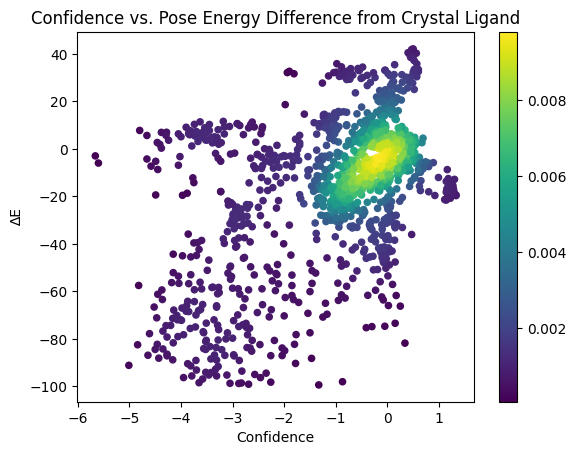

In [81]:

def list_confidences(pose_dir):
    protein = os.path.dirname(pose_dir)[-4:]
    crystal_mol = Chem.MolFromMolFile(os.path.join(os.path.dirname(pose_dir), f"{protein}_ligand.sdf"))
    cry_e = calc_energy(crystal_mol)
    cry_pos, c_fail = get_mol_pos(crystal_mol)
    energies = []
    confidences = []
    rmsds = []
    for name in os.listdir(pose_dir):
        if "confidence" in name:
            confidence_match = re.search(pattern, name)
            confidence_number = float(confidence_match.group(1)) if confidence_match else None
            

            pose_mol = Chem.MolFromMolFile(os.path.join(pose_dir,name))
            energy_diff = cry_e - calc_energy(pose_mol)
            if np.abs(energy_diff) > 100:
                continue

            pose_pos, p_fail = get_mol_pos(pose_mol)
            if c_fail or p_fail:
                continue
            rmsds.append(rmsd(cry_pos, pose_pos))
            
            energies.append(energy_diff)
            confidences.append(confidence_number)
    return {"confidences": confidences, 'energies': energies, 'rmsds': rmsds}


e_p_df = pd.DataFrame(list(df['pose_dir'].iloc[:50].apply(list_confidences)))
x = np.hstack(e_p_df.confidences)
y = np.hstack(e_p_df.energies)
xy = np.vstack([x,y])
kde = gaussian_kde(xy)(xy)

plt.scatter(x, y, c=kde, s=20)
plt.colorbar()
plt.xlabel("Confidence")
plt.ylabel("∆E")
#lt.xlim(-1,1)
#plt.ylim(-25,25)
plt.title("Confidence vs. Pose Energy Difference from Crystal Ligand")

Text(0, 0.5, 'RMSD')

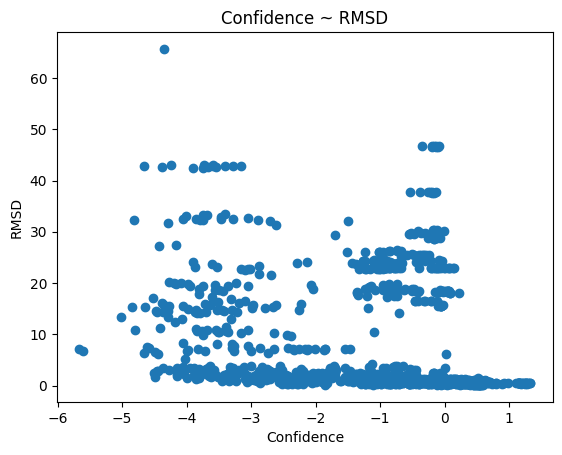

In [82]:
plt.scatter(np.hstack(e_p_df.confidences), np.hstack(e_p_df.rmsds))

plt.title("Confidence ~ RMSD")
plt.xlabel("Confidence")
plt.ylabel("RMSD")

Text(0, 0.5, 'RMSD')

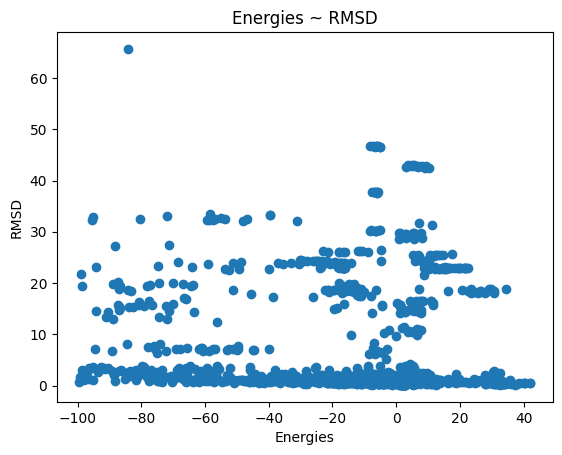

In [83]:
plt.scatter(np.hstack(e_p_df.energies), np.hstack(e_p_df.rmsds))
plt.title("Energies ~ RMSD")
plt.xlabel("Energies")
plt.ylabel("RMSD")

Text(0.5, 1.0, 'Confidence vs. Difference in Strain')

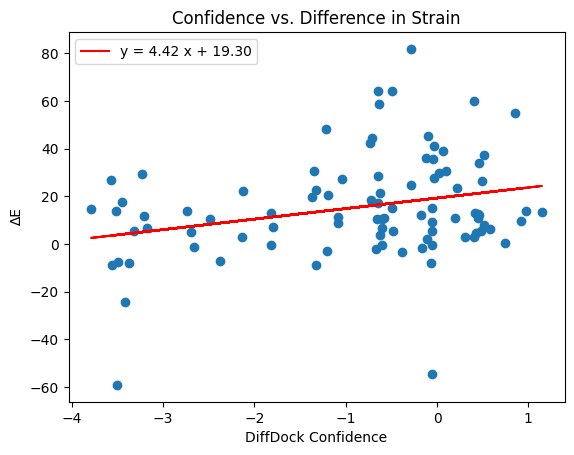

In [84]:
x = df['confidence']
y = df['e_diff']
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, a*x + b, color = 'red',label = f"y = {a:.2f} x + {b:.2f}")
plt.legend()
plt.xlabel("DiffDock Confidence")
plt.ylabel("∆E")
plt.title("Confidence vs. Difference in Strain")

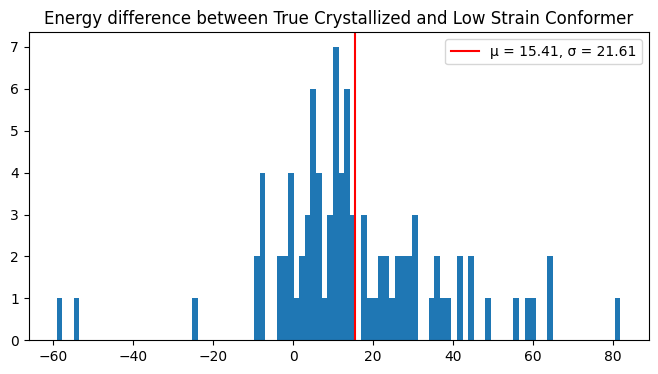

In [85]:
plt.figure(figsize=(8, 4))
plt.hist(df.e_diff, bins = 100)
plt.title("Energy difference between True Crystallized and Low Strain Conformer")
plt.axvline(np.mean(df.e_diff), color = 'r', label = f"µ = {np.mean(df.e_diff):.2f}, σ = {np.std(df.e_diff):.2f}")
plt.legend()
plt.savefig("e_diff.png")

# Continue as before

In [86]:
num_tests = 300
data_df = data_df.iloc[:num_tests]
# get LM embeddings
print("Generating ESM language model embeddings")
model_location = "DiffDock/esm/model_weights/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt"
if not os.path.isfile(model_location):
    model_location = "esm2_t33_650M_UR50D" # esm will download the file automatically. Note that it is about 2.5gb
model, alphabet = pretrained.load_model_and_alphabet(model_location)
model.eval()
if torch.cuda.is_available():
    model = model.cuda()


protein_sequences = [get_sequences_from_pdbfile(f) for f in data_df['protein_files']]

labels, sequences = [], []
for i in range(len(protein_sequences)):
    s = protein_sequences[i].split(':')
    sequences.extend(s)
    labels.extend([data_df['complex_name'].iloc[i] + '_chain_' + str(j) for j in range(len(s))])

lm_embeddings_out = compute_ESM_embeddings(model, alphabet, labels, sequences)

lm_embeddings = []
for i in range(len(protein_sequences)):
    s = protein_sequences[i].split(':')
    lm_embeddings.append([lm_embeddings_out[f"{data_df['complex_name'].iloc[i]}_chain_{j}"] for j in range(len(s))])

data_df['lm_embeddings'] = pd.Series(lm_embeddings, index = data_df['protein_files'].index)

Generating ESM language model embeddings
encountered unknown AA:  KCX  in the complex. Replacing it with a dash - .
encountered unknown AA:  KCX  in the complex. Replacing it with a dash - .
encountered unknown AA:  TPO  in the complex. Replacing it with a dash - .
encountered unknown AA:  SEP  in the complex. Replacing it with a dash - .
encountered unknown AA:  PCA  in the complex. Replacing it with a dash - .
encountered unknown AA:  PTR  in the complex. Replacing it with a dash - .
encountered unknown AA:  CSD  in the complex. Replacing it with a dash - .
encountered unknown AA:  LLP  in the complex. Replacing it with a dash - .
encountered unknown AA:  LLP  in the complex. Replacing it with a dash - .
Processing 1 of 15 batches (33 sequences)
Processing 2 of 15 batches (25 sequences)
Processing 3 of 15 batches (21 sequences)
Processing 4 of 15 batches (17 sequences)
Processing 5 of 15 batches (14 sequences)
Processing 6 of 15 batches (12 sequences)
Processing 7 of 15 batches (12 s

We can now begin inference. Simultaneously, we will calculate the values of our baselines for which we compare to.

In [ ]:

dataset = MiniInferenceDataset(data_df, 'complex_name', 'protein_files', 'ligand_dirs', ligand_descriptors, 'lm_embeddings', confidence_args)
batch_size = 1
shuffle_data = False
num_workers = 0 # No gpu available, but the following is boilerplate code for gpu

loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle_data, num_workers=num_workers)

pattern = re.compile(r'confidence(-?\d+\.\d+)')  # regex to extract confidence number in filename
rmsds = []
cry_Es = []
dock_Es = []
model_confidences = []
baseline_confidences = []

with torch.no_grad():
    confidence_model.eval()
    for j, batch in enumerate(tqdm.tqdm(loader)):
        try:
            mask = []
            batch_true_rmsd = []
            batch_cry_E = []
            batch_dock_E = []
            for i, complex_graph in enumerate(batch.to_data_list()):
                
                    confidence_match = re.search(pattern, complex_graph.name[1])
                    confidence_number = float(confidence_match.group(1)) if confidence_match else None

                    cry_mol = Chem.SDMolSupplier(os.path.join(os.path.dirname(complex_graph.dir),f"{complex_graph.name[0]}_ligand.sdf"))[0]
                    dock_mol = Chem.SDMolSupplier(os.path.join(complex_graph.dir, complex_graph.name[1]))[0]
                    if AllChem.EmbedMolecule(cry_mol) or AllChem.EmbedMolecule(dock_mol):
                        continue    
                    cry_pos, c_fail = get_mol_pos(cry_mol)
                    dock_pos, d_fail = get_mol_pos(dock_mol)
                    if c_fail or d_fail:
                        continue
                    mask.append(i)
                    
                    assert cry_pos.shape == dock_pos.shape
                    batch_true_rmsd.append(rmsd(cry_pos, dock_pos))
                    batch_cry_E.append(calc_energy(cry_mol))
                    batch_dock_E.append(calc_energy(dock_mol))
          
            out = [float(a) for a in confidence_model(batch)[mask,1]]
            if out:
                baseline_confidences.append(confidence_number)
                model_confidences += out
                rmsds += batch_true_rmsd
                dock_Es += batch_dock_E
                cry_Es += batch_cry_E
            else:
                print("Ah-ha!")
        except KeyboardInterrupt as e:
            raise e
        
        except:
            print(f"Failure occurred at index {j}")
        
        #print(confidence_model(batch)[:,1])
        #print("Batch:", confidence_model(batch))

In [172]:
assert len(model_confidences) == len(baseline_confidences)

In [187]:
pred_df = pd.DataFrame({"new_confidence" : model_confidences, "baseline_confidence": baseline_confidences, "rmsds": rmsds, "dock_Es": dock_Es, "cry_Es": cry_Es})

pred_df.to_csv("results.csv")

## Analysis/Post-Processing


In [27]:
df = pd.read_csv("results.csv")
print(df.head())
model_confidences = df["new_confidence"]
baseline_confidences =df["baseline_confidence"]
rmsds = df["rmsds"]
dock_Es = df["dock_Es"]

   Unnamed: 0  new_confidence  baseline_confidence     rmsds     dock_Es  \
0           0        0.333903             7.103457  7.103457  301.216939   
1           1        0.334068             7.040046  7.040046  298.677815   
2           2        0.335110             6.891949  6.891949  323.960942   
3           3        0.334083             2.867017  2.867017  320.188572   
4           4        0.335310             1.679777  1.679777  352.581803   

       cry_Es  
0  638.061606  
1  516.244322  
2  382.743906  
3  374.463643  
4  437.171158  


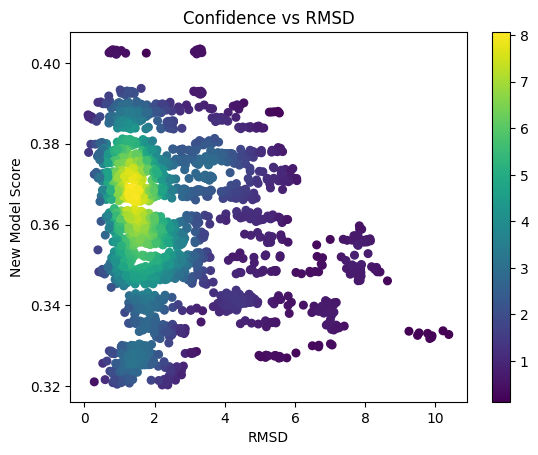

In [14]:

model_confidences = np.array(model_confidences)
# baseline_confidences = np.array(baseline_confidences)[:model_confidences.shape[0]]
rmsds = np.array(rmsds)
# Calculate the point density
xy = np.vstack([rmsds,model_confidences])
kde = gaussian_kde(xy)(xy)

plt.scatter(rmsds, model_confidences, c=kde, s=30)

plt.xlabel("RMSD")
plt.ylabel("New Model Score")
plt.title("Confidence vs RMSD | β = -0.1209")
plt.colorbar()
plt.show()

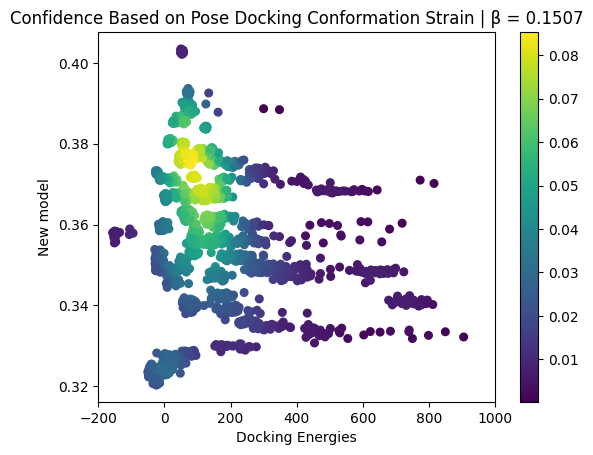

In [21]:
model_confidences = np.array(model_confidences)
# baseline_confidences = np.array(baseline_confidences)[:model_confidences.shape[0]]
dock_Es = np.array(dock_Es)
# Calculate the point density
xy = np.vstack([dock_Es,model_confidences])
kde = gaussian_kde(xy)(xy)

plt.scatter(dock_Es, model_confidences, c=kde, s=30)

plt.xlabel("Docking Energies")
plt.xlim(-200, 1000)
plt.ylabel("New model")
plt.title("Confidence Based on Pose Docking Conformation Strain | β = 0.1507")
plt.colorbar()
plt.show()

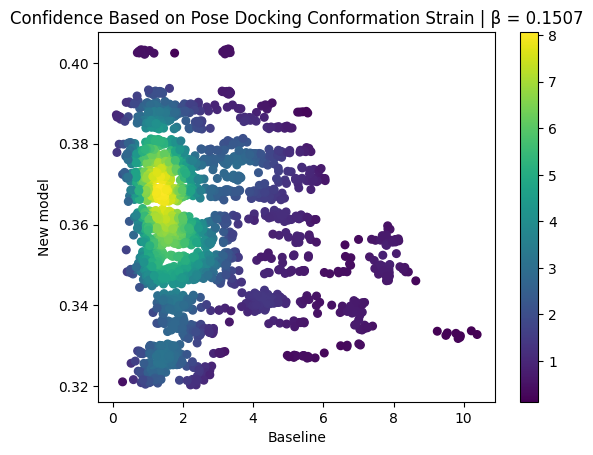

In [26]:
model_confidences = np.array(model_confidences)
# baseline_confidences = np.array(baseline_confidences)[:model_confidences.shape[0]]
baseline_confidences = np.array(baseline_confidences)
# Calculate the point density
xy = np.vstack([baseline_confidences,model_confidences])
kde = gaussian_kde(xy)(xy)

plt.scatter(baseline_confidences, model_confidences, c=kde, s=30)

plt.xlabel("Baseline")
plt.ylabel("New model")
plt.title("Confidence Based on Pose Docking Conformation Strain | β = 0.1507")
plt.colorbar()
plt.show()

In [24]:
from scipy.stats import pearsonr
print(pearsonr(rmsds, model_confidences))
print(pearsonr(dock_Es, model_confidences))

PearsonRResult(statistic=-0.12098551714823798, pvalue=3.838482235163766e-09)
PearsonRResult(statistic=-0.1506635563080909, pvalue=1.965504391714039e-13)
PearsonRResult(statistic=-0.12098551714823798, pvalue=3.838482235163766e-09)


In [164]:
# Calculate percentage accuracy
rmsds = np.array(rmsds)
num_ligs = rmsds.shape[0]
num_under_2A = len(rmsds[rmsds < 2.])/num_ligs
baseline_under_2A = len(baseline_confidences[baseline_confidences > 0])/num_ligs
model_under_2A = len(model_confidences[model_confidences > 0])/num_ligs
print(f"--- Percent of DiffDock poses under 2A ---\nTrue: {num_under_2A:.3f}\nDiffDock Baseline: {baseline_under_2A:.3f}\nNew Model: {model_under_2A:.3f}")


--- Percent of DiffDock poses under 2A ---
True: 0.479
DiffDock Baseline: 0.178
New Model: 0.995


For a ranking model, there are not too many other metrics to compare. Corso et al. measured the effect of dropping low confidence scores, but for our new model, our confidence values are all clustered closely to 0, which means that it is not particularly meaningful to drop results as the output is much more likely to be completely due to random variation.

## Limitations
Although the model is able to pass messages through the global node, the node itself has a very limited representation due low dimensionality. Furthermore, I did not have the time to implement an interesting featurization for this global context. In my mind-map, there were a few suggestions such as conformational strain, energy, free energy, steric hindrance, etc. 

In addition, the global context only directly passed messages to and from the ligand nodes, and I did not implement any intra-global message passing (there was only 1 global node). Furthermore, there was no edge featurization to the edges between the ligand and global context. Due to the way the embeddings worked, information about the weights and values of the global nodes were not particularly informative. Although creating a hacky solution on top of an existing library was a quick way to code up the idea, starting from the ground up without the model complexity in the way would have made the impact of this new global context less opaque.

Other more minor limitations involved: lack of randomization of our dataset; insufficient computation for training; insufficient computation for inference. Lack of testing for gpu-optimization.

## Discussion and Next Steps

The main task at hand is to better learn the complicated distribution of docked poses. We are using the ligand information and bond information, but the interactions between the protein and ligand as well as general forcefield interactions are not being included into our model. There is research that suggests incorporating Molecular Dynamics (MD) information can improve binding affinity score functions [1,2,3]. I will talk more about this in the presentation, but on a physical level, binding affinity is entirely a function of the free energy between the bound and unbound ligand. Unfortunately, MD simulations suffer from being

1. Extremely slow, often 10^8 timesteps are needed for any reasonably accurate MD simulation, and
2. Difficult to program for a large number of different proteins. Majority of MD software is made to closely understand the structure of a particular molecule/system, not run optimization over a large 20k-size dataset.

However, recent advancements like Anton 3 [9] and ML-optimized MD libraries like JAX-MD and torchmd have made these simulations far more feasible and end-to-end differentiable. There are two main components of this diffusion/confidence model architecture that I believe MD could dramatically improve.

1. With the new global context, we can include features such as free energy estimates, conformational strain, binding affinity estimates, etc. Incorporating this information as a feature during prediction could be very strong.
2. Penalizing the diffusive model with MD-computed values such as free energy.

Furthermore, to reach a final state, one could combine a diffusive model/docking model with MD simulations. The idea is called "Dynamic docking" and involves computing a docked pose and then running an MD simulation to let the ligand-protein system equilibrate. Upon equilibration, the state of the system would be distributed according to the Boltzmann-Gibbs distribution, and the conformation with the lowest free energy is equivalent to the distribution's mode. With sufficient sampling, one could output an estimate for this mode as the docked pose prediction. This idea was proposed by Gioia et al. in 2017 and seen as computationally infeasible, but recent advances in hardware as well as quick machine learned potentials that do not sacrifice accuracy can make this possible.

Another option that would be less computationally expensive would include running simulations starting from the docked pose, and simply using moments of the resulting conformation and energy distribution as features of the model. 

In the context of protein-protein interactions with a ligand glue, one of the main ways to understand how a ligand is changing these functions is through MD simulations and observing the trajectory of the protein and how it changes when the drug binds/unbinds. One can used enhanced sampling methods and steered molecular dynamics simulations to speed up the process of these events occurring.

## Apo/Holo Brainstorming
Cusco et al. hypothesized that their diffusive model did a better job in docking into apo-conformation proteins compared to standard docking models due to learning a probability distribution of docked poses rather than looking for a perfect lock-and-key. Of course, this distribution is multi-modal and extremely high-dimensional, but nonetheless we can hope to incorporate some features that model this distribution. In particular, with the new global context, one can imagine using prior knowledge (either from a model or experimentally) to find the sites where binding sites are more plausible. We can then add an additional global node that is both connected to the ligand *as well as the prominent binding sites*. In this way, when we message pass through the GNN, information about how the ligand might interact with far away but crucial parts of the protein can be represented through our model. This comes at a fairly mild computational cost, as we are only making at most `protein.num_nodes + ligand.num_nodes` number of edges. Of course, since all of the information would be passing through a single node, it is likely that the node representation is not sufficiently complex enough, but this could be remedied with adding more nodes at the price of computation.  

In the context of using MD simulations, the protein is changing conformation as we move forwards in the simulation. Hence by a simple RMDS calculation, we can see which docked poses are changing and truly binding to the apo-conformation protein.
ary 2022. arXiv:2107.03813 [cs].

2



## References  

[1]	Milad Rayka and Rohoullah Firouzi. GB-score: Minimally designed machine learning scoring function based on distance-weighted interatomic contact features. Molecular Informatics, 42(3):e2200135, March 2023.  
[2]	Takako Sakano, Md. Iqbal Mahamood, Takefumi Yamashita, and Hideaki Fujitani. Molecular dynamics analysis to evaluate docking pose prediction. Biophysics and Physicobiology, 13:181–194, July 2016.  
[3]	Hugo Guterres and Wonpil Im. Improving Protein-Ligand Docking Results with High-Throughput Molecular Dynamics Simulations. Journal of Chemical Information and Modeling, 60(4):2189–2198, April 2020. Publisher: American Chemical Society.  
[4]	Dario Gioia, Martina Bertazzo, Maurizio Recanatini, Matteo Masetti, and Andrea Cavalli. Dynamic Docking: A Paradigm Shift in Computational Drug Discovery. Molecules, 22(11):2029, November 2017. Number: 11 Publisher: Multidisciplinary Digital Publishing Institute.  
[5]	Raimondas Galvelis, Alejandro Varela-Rial, Stefan Doerr, Roberto Fino, Peter Eastman, Thomas E. Markland, John D. Chodera, and Gianni De Fabritiis. NNP/MM: Accelerating Molecular Dynamics Simulations with Machine Learning Potentials and Molecular Mechanics. Journal of Chemical Information and Modeling, 63(18):5701–5708, September 2023. Publisher: American Chemical Society.  
[6]	Adam Liwo, Cezary Czaplewski, Adam K. Sieradzan, Agnieszka G. Lipska, Sergey A. Samsonov, and Rajesh K. Murarka. Theory and Practice of Coarse-Grained Molecular Dynamics of Biologically Important Systems. Biomolecules, 11(9):1347, September 2021.  
[7]	Efrem Braun, Justin Gilmer, Heather B. Mayes, David L. Mobley, Jacob I. Monroe, Samarjeet Prasad, and Daniel M. Zuckerman. Best Practices for Foundations in Molecular Simulations [Article v1.0]. Living journal of computational molecular science, 1(1):5957, 2019.  
[8]	Brooke E. Husic, Nicholas E. Charron, Dominik Lemm, Jiang Wang, Adrià Pérez, Maciej Majewski, Andreas Krämer, Yaoyi Chen, Simon Olsson, Gianni de Fabritiis, Frank Noé, and Cecilia Clementi. Coarse graining molecular dynamics with graph neural networks. The Journal of Chemical Physics, 153(19):194101, November 2020.  
[9]	David E. Shaw, Peter J. Adams, Asaph Azaria, Joseph A. Bank, Brannon Batson, Alistair Bell, Michael Bergdorf, Jhanvi Bhatt, J. Adam Butts, Timothy Correia, Robert M. Dirks, Ron O. Dror, Michael P. Eastwood, Bruce Edwards, Amos Even, Peter Feldmann, Michael Fenn, Christopher H. Fenton, Anthony Forte, Joseph Gagliardo, Gennette Gill, Maria Gorlatova, Brian Greskamp, J.P. Grossman, Justin Gullingsrud, Anissa Harper, William Hasenplaugh, Mark Heily, Benjamin Colin Heshmat, Jeremy Hunt, Douglas J. Ierardi, Lev Iserovich, Bryan L. Jackson, Nick P. Johnson, Mollie M. Kirk, John L. Klepeis, Jeffrey S. Kuskin, Kenneth M. Mackenzie, Roy J. Mader, Richard McGowen, Adam McLaughlin, Mark A. Moraes, Mohamed H. Nasr, Lawrence J. Nociolo, Lief O’Donnell, Andrew Parker, Jon L. Peticolas, Goran Pocina, Cristian Predescu, Terry Quan, John K. Salmon, Carl Schwink, Keun Sup Shim, Naseer Siddique, Jochen Spengler, Tamas Szalay, Raymond Tabladillo, Reinhard Tartler, Andrew G. Taube, Michael Theobald, Brian Towles, William Vick, Stanley C. Wang, Michael Wazlowski, Madeleine J. Weingarten, John M. Williams, and Kevin A. Yuh. Anton 3: twenty microseconds of molecular dynamics simulation before lunch. In Proceedings of the International Conference for High Performance Computing, Networking, Storage and Analysis, SC ’21, pages 1–11, New York, NY, USA, November 2021. Association for Computing Machinery.  
[10]	Tai-Sung Lee, Bryce K. Allen, Timothy J. Giese, Zhenyu Guo, Pengfei Li, Charles Lin, T. Dwight Jr. McGee, David A. Pearlman, Brian K. Radak, Yujun Tao, Hsu-Chun Tsai, Huafeng Xu, Woody Sherman, and Darrin M. York. Alchemical Binding Free Energy Calculations in AMBER20: Advances and Best Practices for Drug Discovery. Journal of Chemical Information and Modeling, 60(11):5595–5623, November 2020. Publisher: American Chemical Society.  
[11]	Yitong Pang, Lingfei Wu, Qi Shen, Yiming Zhang, Zhihua Wei, Fangli Xu, Ethan Chang, Bo Long, and Jian Pei. Heterogeneous Global Graph Neural Networks for Personalized Session-based Recommendation. In Proceedings of the Fifteenth ACM International Conference on Web Search and Data Mining, pages 775–783, February 2022. arXiv:2107.03813 [cs].
